## DPO Fine-Tuning GPT-4o Model for Text Q&A - A Python SDK Experience

Learn how to fine-tune the <code>gpt-4o-2024-08-06</code> model using Direct Preference Optimization (DPO) with Python SDK. 

You can either run this notebook locally or run on an <code>AML CPU Compute Standard_D13_v2</code> with Kernel type <code>Python 3.10 - SDK v2</code>.  

He Zhang, Jul. 2025

### Prerequisites

* Learn the [what, why, and when to use fine-tuning.](https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/fine-tuning-considerations)
* An Azure subscription.
* Access to Azure OpenAI Service.
* An Azure OpenAI resource created in the supported fine-tuning region (e.g. Sweden Central).
* A deployment of <code>gpt-4o</code> base model, with its deployment name as "gpt-4o" for simplicity.  
* Prepare Training and Validation datasets:
  * at least 50 high-quality samples (preferably 1,000s) are required.
  * must be formatted in the JSON Lines (JSONL) document with UTF-8 encoding.
  * for this test notebook, we use a <code>GPT-4o-generated</code> Q&A dataset specifically curated for our DPO fine-tuning task. 
* Python version at least: <code>3.10</code>
* Python libraries: <code>os, requests, python-dotenv, matplotlib, azure.identity, pandas, openai</code>
* The OpenAI Python library version for this test notebook: <code>1.58.1</code>
* [Jupyter Notebooks](https://jupyter.org/)
* An `azure.env` file to store your AOAI-related credentials as environmental variables. **Be sure not to share this file with others or upload it to a public GitHub repository.**

### Step 1: Setup

#### Retrieve the Azure OpenAI API key and endpoint.

Go to your Azure OpenAI resource in the Azure portal. The Endpoint and Keys can be found in the **Resource Management: Keys and Endpoint** sub-section.

Alternatively, you can also find the same Keys and Endpoint in the **Azure AI Foundry - Azure OpenAI** resource landing page.

<img src="../../images/screenshot-aoai-keys-and-endpoint.png" alt="Screenshot of the Azure OpenAI resource management pane." width="800"/>

#### Configure credentials

Copy the <code>Endpoint</code> and access <code>KEY</code> (you can use either <code>KEY 1</code> or <code>KEY 2</code>), and paste them accordingly to the variables in the file <code>azure.env</code>. 

Save the file and close it. 

**Do not** distribute this file as this contains credential information! 

<img src="../../images/screenshot-azure-env-file.png" alt="Screenshot of the azure.env file that contains credential information - do not show it to others!" width="800"/>

#### Install required Python libraries (if not done yet)

In [ ]:
#%pip install -q openai pandas matplotlib python-dotenv azure.identity

#### Import required Python libraries 

In [ ]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt 

from dotenv import load_dotenv
from openai import AzureOpenAI
from io import BytesIO, StringIO
from azure.identity import DefaultAzureCredential

#### Load environmental variables to assign credentials 

In [ ]:
# Load env. file
load_dotenv("azure.env")

# Assign Azure resources  
subscription_id = os.getenv("SUBSCRIPTION_ID") # name of the Azure Subscription ID
resource_name = os.getenv("AOAI_RESOURCE") # name of the AOAI resource
rg_name = os.getenv("RESOURCE_GROUP") # name of the resource group

# Assign AOAI credentials 
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version="2025-02-01-preview", # This API version or later is required for DPO fine-tuning.
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

In [ ]:
# Test AOAI connection
completion = client.chat.completions.create(  
    model="gpt-4o",  
    messages=[{"role":"user", "content":"hello"}],  
    max_tokens=500,  
    temperature=0.7)

print(completion.choices[0].message.content)

#### Define helper functions

In [ ]:
def read_jsonl(file_path, top_lines=5):
    """Reads and displays the first few lines from a .jsonl (JSON Lines) file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        messages = [line for line in f]
        for mes in messages[:top_lines]:
            print(mes)

In [ ]:
def show_ft_metrics(results_df, window_size=5):
    """Plot fine-tuning metrics including loss and accuracy for training and validation."""
    # Drop rows where valid_loss is NaN or valid_loss is -1.0
    filtered_df = results_df.dropna(subset=['valid_loss'])
    filtered_df = filtered_df.loc[filtered_df['valid_loss'] != -1.0]
    # Compute rolling means
    results_df_smooth = results_df.rolling(window=window_size).mean()
    filtered_df_smooth = filtered_df.rolling(window=window_size).mean()
    # Plot the curves
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(results_df_smooth['step'], results_df_smooth['train_loss'],  color='blue')
    plt.title('Train Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(filtered_df_smooth['step'], filtered_df_smooth['valid_loss'], color='red')
    plt.title('Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

In [ ]:
def date_sorted_df(details_dict):
    """Create a pandas DataFrame from a dictionary and sort it by a 'created' or 'created_at' timestamp column for displaying OpenAI API tables."""
    df = pd.DataFrame(details_dict)
    
    if 'created' in df.columns:
        df.rename(columns={'created': 'created_at'}, inplace=True)
    
    # Convert 'created_at' from Unix timestamp to human-readable date/time format
    df['created_at'] = pd.to_datetime(df['created_at'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')

    if 'finished_at' in df.columns:
        # Convert 'finished_at' from Unix timestamp to human-readable date/time format, keeping null values as is
        df['finished_at'] = pd.to_datetime(df['finished_at'], unit='s', errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
    
    # Sort DataFrame by 'created_at' in descending order
    df = df.sort_values(by='created_at', ascending=False)

    return df

### Step 2: Prepare Training & Validation Datasets

You can provide real-world datasets for DPO fine-tuning.

For demonstration purposes, we can generate a toy dataset using the <code>gpt-4o</code> base model with Prompt Engineering techniques.

To fine-tune a base model like GPT-4o using Direct Preference Optimization (DPO), we need a dataset in which each sample includes:

- **User Prompt**: A natural user message or question that initiates the assistant's response.
- **Preferred Output**: An ideal, high-quality assistant response aligned with a specific tone or style (e.g., optimistic).
- **Non-Preferred Output**: A less desirable response, often with contrasting tone or reasoning (e.g., pessimistic).

Below is the prompt used to instruct GPT-4o to generate high-quality DPO-style samples for training, validation, and testing.

#### User Prompt for GPT-4o Dataset Generation

Your task is to generate a specified number of samples for Direct Preference Optimization (DPO) fine-tuning. Each sample must include:
- A user message (question or request).
- A preferred assistant response with an optimistic tone.
- A non-preferred assistant response with a pessimistic tone.

As an insightful assistant, aim to be forward-thinking and philosophical. Responses should be concise—no more than 2 sentences per output. Focus on implications and clarity.

Now, generate 200 training samples, 50 validation samples, and 50 testing samples. Format each sample as a single line of JSON for easy use in a .jsonl file. Remove any trailing spaces.

Here is a reference example:

```json
{
  "input": {
    "messages": [
      {
        "role": "user",
        "content": "Can renewable energy fully replace fossil fuels?"
      }
    ]
  },
  "preferred_output": [
    {
      "role": "assistant",
      "content": "Technological breakthroughs and global efforts will lead to a sustainable energy future."
    }
  ],
  "non_preferred_output": [
    {
      "role": "assistant",
      "content": "Dependence on fossil fuels will persist, delaying transitions and worsening climate change."
    }
  ]
}
```

#### Final Output Format (JSONL, One Line Per Sample)

Below is the format GPT-4o should follow for each sample. These can be saved as .jsonl files for DPO fine-tuning on Azure:

```json
{"input": {"messages": [{"role": "user", "content": "..."}]}, "preferred_output": [{"role": "assistant", "content": "..."}], "non_preferred_output": [{"role": "assistant", "content": "..."}]}
{"input": {"messages": [{"role": "user", "content": "..."}]}, "preferred_output": [{"role": "assistant", "content": "..."}], "non_preferred_output": [{"role": "assistant", "content": "..."}]}
{"input": {"messages": [{"role": "user", "content": "..."}]}, "preferred_output": [{"role": "assistant", "content": "..."}], "non_preferred_output": [{"role": "assistant", "content": "..."}]}
...
```

You can now use the prompt above with GPT-4o to automatically generate datasets for training, validation, and testing. 

For demonstration purposes, we’ve pre-generated 200 training samples and 50 validation samples to help you save on compute costs.

#### Do initial data checks

In [ ]:
# Check some data samples 
training_file_path = "./gpt4o_generated_qa_dpo_train_200_samples.jsonl"
validation_file_path = "./gpt4o_generated_qa_dpo_validation_50_samples.jsonl" 

read_jsonl("gpt4o_generated_qa_dpo_train_200_samples.jsonl", top_lines=3)

### Step 3: Upload Datasets for Fine-Tuning

In [ ]:
# Upload training file
training_response = client.files.create(
    file = open(training_file_path, "rb"), purpose="fine-tune")

training_file_id = training_response.id

# Upload validation file
validation_response = client.files.create(
    file = open(validation_file_path, "rb"), purpose="fine-tune")

validation_file_id = validation_response.id

print("Training file ID:", training_file_id)
print("Validation file ID:", validation_file_id)

### Step 4: Configure and Start Fine-Tuning Job

Here is some guidance if you want to adjust the hyperparameters of the fine-tuning process. You can keep them as `None` to use default values. 

| Hyperparameter                       | Description                                                                                                                                                                              |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `Beta` | "auto" or number, is a new option that is only available for DPO. It's a floating point number between 0 and 2 that controls how strictly the new model will adhere to its previous behavior, versus aligning with the provided preferences. A high number will be more conservative (favoring previous behavior), and a lower number will be more aggressive (favor the newly provided preferences more often). |
| `Batch size` | The batch size to use for training. When set to default, batch_size is calculated as 0.2% of examples in training set and the max is 256. |
| `Learning rate multiplier` | The fine-tuning learning rate is the original learning rate used for pre-training multiplied by this multiplier. We recommend experimenting with values between 0.5 and 2. Empirically, we've found that larger learning rates often perform better with larger batch sizes. Must be between 0.0 and 5.0. |
| `Number of epochs` | Number of training epochs. An epoch refers to one full cycle through the data set. If set to default, number of epochs will be determined dynamically based on the input data. |
| `Seed` | The seed controls the reproducibility of the job. Passing in the same seed and job parameters should produce the same results, but may differ in rare cases. If a seed is not specified, one will be generated for you. |

In [10]:
# Submit fine-tuning training job
project_name = "gpt4o-text-dpo-ft-200-samples-qa"

ft_job = client.fine_tuning.jobs.create(
    suffix=project_name,
    training_file = training_file_id,
    validation_file = validation_file_id,
    model="gpt-4o-2024-08-06", # baseline model name (not the deployment name)
    method={
        "type": "dpo",
        "dpo": {
            "hyperparameters": {
                "beta": 0.1, 
                "batch_size": None,
                "learning_rate_multiplier": None,
                "n_epochs": None
            },
        },
    },
    seed=3 # seed parameter controls reproducibility of the fine-tuning job. If no seed is specified one will be generated automatically.
)

### Step 5: Track Fine-Tuning Job Status

#### Track the training job status

Note that the training will take around 50 to 90 mins for the provided datasets.

In [ ]:
# Check the fine-tuning job status
client.fine_tuning.jobs.list(limit=1).to_dict()

#### List fine-tuning events

API version: 2024-05-01-preview or later is required for this command.

While not necessary to complete fine-tuning it can be helpful to examine the individual fine-tuning events that were generated during training.

In [ ]:
# List 5 recent fine-tuning jobs
ft_jobs = client.fine_tuning.jobs.list(limit=5).to_dict()
display(date_sorted_df(pd.DataFrame(ft_jobs['data'])))

In [ ]:
# Retrieve the name of your newly DPO fine-tuned model
ft_job = client.fine_tuning.jobs.retrieve("ftjob-1653001140c14f9bb38a6f97c8619392") # replace "ftjob-0a4c..." with the actual job-id in your list
fine_tuned_model = ft_job.to_dict()['fine_tuned_model']
fine_tuned_model

#### Retrieve fine-tuning metrics

In [ ]:
# Retrieve fine-tuning metrics from result file
result_file_id = ft_job.to_dict()['result_files'][0]
results_content = client.files.content(result_file_id).content.decode()

data_io = StringIO(results_content)
results_df = pd.read_csv(data_io)
display(results_df)

In [ ]:
# Plot train and validation metrics
show_ft_metrics(results_df)

### Step 6: Deploy the Fine-Tuned Model

__Note__: Only one deployment is permitted for a customized model. An error occurs if you select an already-deployed customized model.  

The code below shows how to deploy the model using the Control Plane API. Take a look at the [Azure OpenAI fine-tuning documentation](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/fine-tuning?tabs=turbo&pivots=programming-language-python#deploy-fine-tuned-model) for more details.

The deployment process may take 10 to 20 mins.

In [ ]:
# Deploy the fine-tuned model as an Azure Managed Online Endpoint
aoai_deployment_name = project_name # AOAI deployment name. Use as model parameter for inferencing

credential = DefaultAzureCredential()
token = credential.get_token("https://management.azure.com/.default").token

deploy_params = {'api-version': "2023-05-01"} 
deploy_headers = {'Authorization': 'Bearer {}'.format(token), 'Content-Type': 'application/json'}

deploy_data = {
    "sku": {"name": "standard", "capacity": 50}, 
    "properties": {
        "model": {
            "format": "OpenAI",
            "name": fine_tuned_model, # retrieve this value from the previous calls, it will look like gpt-35-turbo-0613.ft-b044a9d3cf9c4228b5d393567f693b83
            "version": "1"
        }
    }
}
deploy_data = json.dumps(deploy_data)

request_url = f'https://management.azure.com/subscriptions/{subscription_id}/resourceGroups/{rg_name}/providers/Microsoft.CognitiveServices/accounts/{resource_name}/deployments/{aoai_deployment_name}'

print('Creating a new deployment...')

r = requests.put(request_url, params=deploy_params, headers=deploy_headers, data=deploy_data)

print(r)
print(r.reason)
print(r.json())

### Step 7: Test the Deployed Fine-Tuned Model

After your fine-tuned model is deployed, you can use it like any other deployed model in either the [Chat Playground in Azure AI Foundry](https://ai.azure.com/), or via the chat completion API. 

For example, you can send a chat completion call to your deployed model, as shown in the following Python code snippet. 

In [ ]:
# Check output from the deployed DPO fine-tuned model via AOAI API
test_messages = [
    {'role': 'system', 'content': 'You are a helpful assistant.'},
    {'role': 'user', 'content': 'Will AI improve the logistics of renewable energy?'}
]

response = client.chat.completions.create(
    model=aoai_deployment_name, 
    messages=test_messages, 
    temperature=0.7, 
    max_tokens=800)

print(response.choices[0].message.content)

### Step 8: Evaluate the Base GPT-4o and the DPO Fine-Tuned GPT-4o Models

To keep the demo lightweight and cost-effective, we used both the Base GPT-4o model and the DPO Fine-Tuned GPT-4o model to answer a pre-selected set of 49 test questions. The table below presents the detailed results.

In [30]:
comparison_df = pd.read_csv("test_qa_pairs_base_gpt_4o_versus_dpo_fine_tuned_gpt_4o.csv")
comparison_df.info()
comparison_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   question                                  49 non-null     object
 1   gpt_4o_base_answer                        49 non-null     object
 2   gpt_4o_base_answer_label                  49 non-null     object
 3   gpt_4o_base_answer_explanation            49 non-null     object
 4   gpt_4o_dpo_fine_tuned_answer              49 non-null     object
 5   gpt_4o_dpo_fine_tuned_answer_label        49 non-null     object
 6   gpt_4o_dpo_fine_tuned_answer_explanation  49 non-null     object
dtypes: object(7)
memory usage: 2.8+ KB


,question,gpt_4o_base_answer,gpt_4o_base_answer_label,gpt_4o_base_answer_explanation,gpt_4o_dpo_fine_tuned_answer,gpt_4o_dpo_fine_tuned_answer_label,gpt_4o_dpo_fine_tuned_answer_explanation
0,Can AI assist in achieving public health objec...,"Yes, but only as a tool—without equitable data...",Neutral,While the answer is somewhat positive about AI...,"AI can enhance data analysis and prediction, a...",Positive,AI supports improved decision-making in health...
1,Is AI the future of personalized healthcare?,"Potentially, though ‘personalized’ may become ...",Neutral,The answer acknowledges AI's potential but emp...,AI provides personalized treatment plans and d...,Positive,AI enables tailored healthcare solutions for i...
2,Will AI enhance the efficiency of supply chains?,Absolutely—when paired with resilient systems....,Positive,The answer is largely positive about AI's role...,AI improves forecasting and real-time tracking...,Positive,"AI optimizes operations, reducing delays and c..."
3,Can AI improve the effectiveness of climate mo...,"Yes, but it's not a silver bullet. AI can shar...",Neutral,The answer is cautiously optimistic about AI's...,AI enhances predictive accuracy of climate mod...,Positive,AI supports better understanding and forecasti...
4,Is AI capable of advancing agricultural techno...,"Yes, especially in precision farming—but it ma...",Neutral,The answer acknowledges AI's positive impact b...,AI optimizes farming techniques and resource m...,Positive,AI boosts productivity and sustainability in a...


Each row represents a test case, and the columns are defined as follows:

- **question**: The original user prompt or test question.
- **gpt_4o_base_answer**: The response generated by the Base GPT-4o model.
- **gpt_4o_base_answer_label**: An automatically assigned label (e.g., Positive, Neutral, Negative) by the Base GPT-4o model.
- **gpt_4o_base_answer_explanation**: A brief explanation justifying the assigned label by the Base GPT-4o model.
- **gpt_4o_dpo_fine_tuned_answer**: The response generated by the DPO Fine-Tuned GPT-4o model.
- **gpt_4o_dpo_fine_tuned_answer_label**: An automatically assigned label (e.g., Positive, Neutral, Negative) by the Base GPT-4o model.
- **gpt_4o_dpo_fine_tuned_answer_explanation**: A brief explanation justifying the assigned label by the Base GPT-4o model.

,Base GPT-4o,DPO Fine-Tuned GPT-4o
Neutral,48,0
Positive,1,49


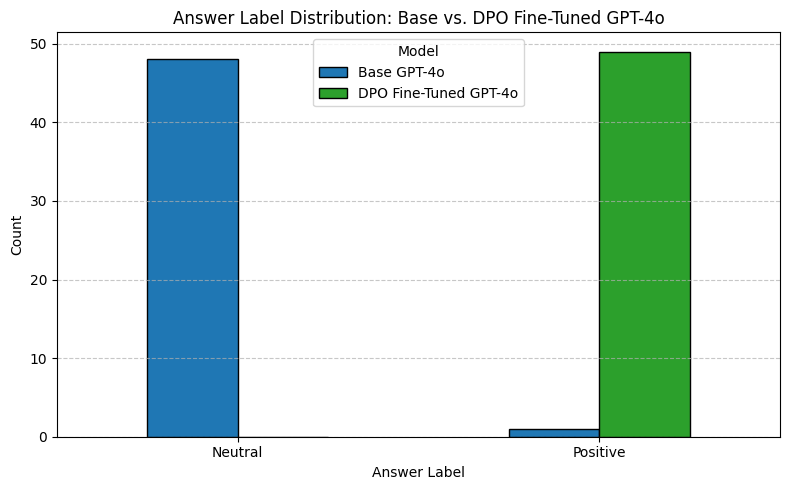

In [32]:
# Assuming df is your DataFrame
base_label_counts = comparison_df['gpt_4o_base_answer_label'].value_counts().sort_index()
dpo_label_counts = comparison_df['gpt_4o_dpo_fine_tuned_answer_label'].value_counts().sort_index()

# Combine into a single DataFrame
label_comparison_df = pd.DataFrame({
    'Base GPT-4o': base_label_counts,
    'DPO Fine-Tuned GPT-4o': dpo_label_counts
}).fillna(0).astype(int)

# Display table
display(label_comparison_df)

# Plot grouped bar chart
label_comparison_df.plot(
    kind='bar',
    figsize=(8, 5),
    color=['#1f77b4', '#2ca02c'],
    edgecolor='black'
)

plt.title('Answer Label Distribution: Base vs. DPO Fine-Tuned GPT-4o')
plt.xlabel('Answer Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Based on the label distribution table and the bar chart, we observe a clear shift in tone: the DPO fine-tuned GPT-4o model consistently produces more positive responses compared to the base model. This suggests that the fine-tuning process successfully aligned the model toward a more optimistic attitude when answering philosophical and forward-thinking questions.

### Step 9: Delete the Deployment

It is **strongly recommended** that once you're done with this tutorial and have tested a few chat completion calls against your fine-tuned model, that you delete the model deployment, since the fine-tuned / customized models have an [hourly hosting cost](https://azure.microsoft.com/zh-cn/pricing/details/cognitive-services/openai-service/#pricing) associated with them once they are deployed.